### Import neccessary libraries

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras
from keras.utils import plot_model
import math
from keras.optimizers import RMSprop
import tensorflow_addons as tfa
import neural_structured_learning as nsl
import os  
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


2023-02-01 11:36:30.764851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 11:36:30.879324: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 11:36:31.429452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-01 11:36:31.429512

### 1. Load the dataset

In [2]:
train_dataset = pd.read_csv("fashion-mnist_train.csv") 
test_dataset = pd.read_csv("fashion-mnist_test.csv")


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

def data_preprocessing(raw): 
    '''
    Preprocess the data 
    @param raw: raw data, contains 785 columns (784 = 28x28 image, 1 label column). 
    @return image: the 28x28 image from the csv file 
    @return label: label of the image
    '''
    label = tf.keras.utils.to_categorical(raw.label, 10)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, 28, 28, 1)
    image = x_shaped_array / 255
    return image, label

X_train, y_train = data_preprocessing(train_dataset)
X_test, y_test = data_preprocessing(test_dataset)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

### 2. Define helper functions

In [3]:
def shuffling_data(x, y):
    ''' 
    Shuffling two numpy arrays, preserve the linked charactersitics of both
    @param x, y: the two array with same length 
    @return x, y shuffled in the same order
    '''
    assert x.shape[0] == y.shape[0]
    p = np.random.permutation(x.shape[0])
    return x[p], y[p]


def display_images(image):
    '''
    display an image using matplotlib and greyscale. Use plt.show().
    @param image to display
    '''
    plt.figure()
    plt.imshow(image,cmap='gray')
    plt.show()
    
    
def generator(x, y, data_gen, subset):
    ''' 
    generate the data using ImageDataGenerator, yield a dictionary  
    as required by nsl's AdversarialRegularization model.  
    Flow now with batch_size=128.
    @param x: Image 
    @param y: label
    @param data_gen: The ImageDataGenerator object from tfa addons.
    @yield dict{feature, label}: Generated feature and label dictionary.
    '''
    data_gen.fit(x)
    for x_batch, y_batch in data_gen.flow(x, y, batch_size=128, subset=subset):
        yield {'feature': x_batch, 'label': y_batch}

        
def dump_pickle(file_name, stuff):
    '''
    dump resources to a file 
    '''
    with open(file_name, "wb") as file:
        pickle.dump(stuff, file)


def print_examples(X_test, y_test, y_pred):
    '''
    print examples: currently set to print some examples that are the most confusing to model. 
    '''
    labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}
    X_test__ = X_test.reshape(X_test.shape[0], 28, 28)
    idx_list = []
    while len(idx_list) < 25:  
        i = random.randint(0, 9999)
        real_label = y_test[i].argmax()
        pred_label = y_pred[i].argmax()
        if pred_label != real_label and pred_label == 0 and real_label == 6 :
            idx_list.append(i)

    fig, axis = plt.subplots(5, 5, figsize=(16, 20))
    for i, ax in enumerate(axis.flat):
        ax.imshow(X_test__[idx_list[i]], cmap='gray')
        ax.set(title = f"Real Class: {labels[y_test[idx_list[i]].argmax()]}\nPredict Class: {labels[y_pred[idx_list[i]].argmax()]}\nNumber: {idx_list[i]}")


def confusion_matrix_plot(y_test, y_pred, title):
    '''
    Plot a confusion matrix between real and predicted class. 
    '''
    y_pred_classes = np.argmax(y_pred, axis = 1)
    y_true = np.argmax(y_test, axis = 1)
    confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

    f,ax = plt.subplots(figsize = (5,5))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="white", fmt='.0f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

### 3. Data Augmentation - Generate a blurred image dataset

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

random_indices_train = np.random.choice(X_train.shape[0], size=20000, replace=False)
random_indices_test = np.random.choice(X_test.shape[0], size=3000, replace=False)


X_train_blur = tfa.image.gaussian_filter2d(X_train[random_indices_train], filter_shape=(2,2)).numpy()
X_test_blur = tfa.image.gaussian_filter2d(X_test[random_indices_test], filter_shape=(2,2)).numpy()

X_train_comby = np.concatenate((X_train, X_train_blur), axis=0)

X_test_comby = np.concatenate((X_test, X_test_blur), axis=0)
y_train_comby = np.concatenate((y_train, y_train[random_indices_train]), axis=0)
y_test_comby = np.concatenate((y_test, y_test[random_indices_test]), axis=0)
X_train_comby, y_train_comby = shuffling_data(X_train_comby, y_train_comby)

2023-02-01 11:36:40.233621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8066 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-02-01 11:36:40.234330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:1c:00.0, compute capability: 8.6
2023-02-01 11:36:40.234995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10092 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:1d:00.0, compute capability: 8.6
2023-02-01 11:36:40.235648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 10092 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:1e:00.0, compute capability: 8.6
2023

### 3. Data Augmentation - Using ImageDataGenerator from Tensorflow to augment the data: 
Additional images: Rotate, shift width, horizontal flip, height shift, and zoom range.
Split a small subset for valitation purposes.

In [5]:
data_augmentor = ImageDataGenerator(rotation_range = 90,
                                    # width_shift_range=0.1,
                                    # height_shift_range=0.1, 
                                    vertical_flip=True,
                                    horizontal_flip=True)

### 4. Load the initial model

In [6]:
model = tf.keras.models.load_model('initial_model')

### 5. Define Categorical CrossEntropy loss and Adam optimizer 
Hyperparameters: learning rate=0.001.

In [7]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

### 6. Define callbacks: 
Callback_cc_loss: Stop training early if the categorical_crossentropy loss does not improve in 3 iterations.
callback_adversarial_loss: Stop training early if the adversarial loss does not improve in 5 iterations.

In [8]:
callback_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
callback_adv_loss = tf.keras.callbacks.EarlyStopping(monitor='scaled_adversarial_loss', patience=5)

### 7. Train the model with augmented data
Train batch size: 128, validate on unaugmented data, epochs=50.

In [11]:
model.fit(data_augmentor.flow(X_train_comby, y_train_comby, batch_size=128),
         validation_data=(X_val, y_val), epochs=50, callbacks=[callback_val_loss])

Epoch 1/50
532/532 [==============================] - 23s 44ms/step - loss: 0.4827 - accuracy: 0.8252 - val_loss: 0.3173 - val_accuracy: 0.8882
Epoch 2/50
532/532 [==============================] - 23s 43ms/step - loss: 0.4769 - accuracy: 0.8282 - val_loss: 0.3351 - val_accuracy: 0.8781
Epoch 3/50
532/532 [==============================] - 23s 43ms/step - loss: 0.4700 - accuracy: 0.8309 - val_loss: 0.3245 - val_accuracy: 0.8826
Epoch 4/50
532/532 [==============================] - 23s 43ms/step - loss: 0.4711 - accuracy: 0.8306 - val_loss: 0.3124 - val_accuracy: 0.8904
Epoch 5/50
532/532 [==============================] - 23s 44ms/step - loss: 0.4672 - accuracy: 0.8326 - val_loss: 0.3051 - val_accuracy: 0.8895
Epoch 6/50
532/532 [==============================] - 22s 42ms/step - loss: 0.4628 - accuracy: 0.8334 - val_loss: 0.3037 - val_accuracy: 0.8958
Epoch 7/50
532/532 [==============================] - 23s 43ms/step - loss: 0.4554 - accuracy: 0.8365 - val_loss: 0.3083 - val_accuracy:

### 8. Evaluate the augmented model

In [12]:
model.evaluate(X_test, y_test) 
model.evaluate(data_augmentor.flow(X_test_comby, y_test_comby))

407/407 [==============================] - 6s 15ms/step - loss: 0.3415 - accuracy: 0.8743


[0.34147053956985474, 0.8743076920509338]

### 9. Save the augmented model 

In [11]:
model.save('initial_augmented_model')

INFO:tensorflow:Assets written to: initial_augmented_model/assets


INFO:tensorflow:Assets written to: initial_augmented_model/assets


### 10. Load the augmented model

In [27]:
model = tf.keras.models.load_model('initial_augmented_model')

### 11. Train and evaluate the augmented model on the initial samples

In [28]:
model.evaluate(X_test, y_test) #), steps=math.ceil(10000/32)

313/313 [==============================] - 5s 15ms/step - loss: 0.2926 - accuracy: 0.8928


[0.29261577129364014, 0.892799973487854]

407/407 [==============================] - 6s 15ms/step - loss: 0.3487 - accuracy: 0.8718


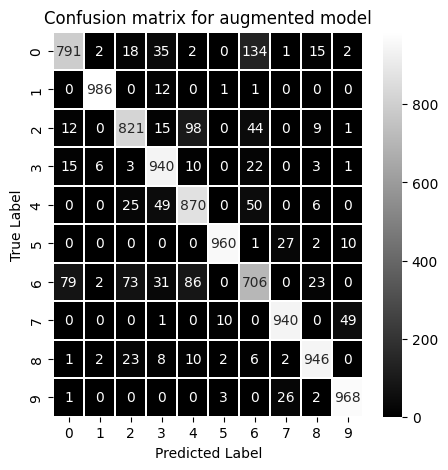

In [31]:
y_pred = model.predict(X_test)
model.evaluate(data_augmentor.flow(X_test_comby, y_test_comby))
confusion_matrix_plot(y_test, y_pred, 'Confusion matrix for augmented model')

# NEXT STEP: Adversarial Regularization

#### Config object with relevant hyperparameters: 
multiplier: How many % of adversarial loss (0-1) to be taken into account in final training, now 0.2
adv_step_size: step size to find adversarial examples, now 0.2
#### Adversarial model wrapped around the original model.

### 12. Train the adversarial model
Apply adversarial pattern to the augmented data also. 

In [14]:
adv_config_02 = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.2)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config_02)
adv_model.compile(optimizer = optimizer,
              loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
# adv_model.fit(generator(X_train, y_train, data_augmentor, subset='training'), batch_size=128, epochs=30, callbacks=[callback_cc_loss], steps_per_epoch=768) 


In [ ]:
adv_model.fit({'feature': X_train, 'label': y_train}, batch_size=128, epochs=50, callbacks=[callback_loss, callback_adv_loss], steps_per_epoch=768)
adv_model.evaluate({'feature': X_test, 'label': y_test[:10000]}, steps=math.ceil(20000/128))

### 13. Evaluate the adversarial model

In [ ]:
#score = adv_model.evaluate(generator(X_test_comby, y_test, data_augmentor, subset='training' ), batch_size=32, steps=math.ceil(10000/32))
#print(score)

### 14. Save the adversarial model

In [ ]:
adv_model.save('adversarial_augmented_model_0.2_noAugOnAdv')

### 15. Train a non-augmented adversarial model

In [15]:
model = tf.keras.models.load_model('initial_model')
adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config_02)
adv_model.compile(optimizer = optimizer,
              loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
adv_model.fit({'feature': X_train, 'label': y_train}, batch_size=128, epochs=50, callbacks=[callback_loss, callback_adv_loss], steps_per_epoch=768)

Epoch 1/50
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


768/768 [==============================] - 18s 19ms/step - loss: 0.1578 - categorical_crossentropy: 0.1048 - categorical_accuracy: 0.9601 - scaled_adversarial_loss: 0.0530
Epoch 2/50
768/768 [==============================] - 15s 20ms/step - loss: 0.1486 - categorical_crossentropy: 0.1008 - categorical_accuracy: 0.9623 - scaled_adversarial_loss: 0.0478
Epoch 3/50
768/768 [==============================] - 17s 22ms/step - loss: 0.1404 - categorical_crossentropy: 0.0958 - categorical_accuracy: 0.9638 - scaled_adversarial_loss: 0.0447
Epoch 4/50
768/768 [==============================] - 16s 21ms/step - loss: 0.1365 - categorical_crossentropy: 0.0937 - categorical_accuracy: 0.9644 - scaled_adversarial_loss: 0.0428
Epoch 5/50
768/768 [==============================] - 16s 21ms/step - loss: 0.1325 - categorical_crossentropy: 0.0902 - categorical_accuracy: 0.9660 - scaled_adversarial_loss: 0.0423
Epoch 6/50
768/768 [==============================] - 16s 21ms/step - loss: 0.1283 - categorical

768/768 [==============================] - 7s 9ms/step - loss: 0.0882 - categorical_crossentropy: 0.0587 - categorical_accuracy: 0.9786 - scaled_adversarial_loss: 0.0295
